## Import libraries

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
#시드값 고정
np.random.seed(42)
%matplotlib inline

#KoNLPy 공식 문서 : https://konlpy.org/ko/latest/
#설치되었는지 확인 : pip install konlpy
from konlpy.tag import Hannanum, Kkma, Komoran, Okt
#LDA : 빈도수 기반 CountVectorizer 사용
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import gensim
#설치되었는지 확인 : pip install pyLDAvis
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [3]:
'''
------Code Lab------
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

mpl.rc('font', family='NanumBarunGothic') 

In [4]:
# 그림 저장
image_path = '/content/drive/MyDrive/LIS3813/images/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = image_path + fig_name + "." + fig_extension
    print("그림 저장: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def get_dct_corpus(year_quarter):
  nouns_list = [n.strip().split(',') for n in tqdm(open(f'/content/drive/MyDrive/LIS3813/datasets/nouns_{year_quarter}.csv', 'r', encoding='utf-8').readlines())][1:]

  #추출한 명사 리스트를 사전으로 만들기
  dic = gensim.corpora.Dictionary(nouns_list)
  
  #빈도가 4번 이하인 명사는 제외
  dic.filter_extremes(no_below = 4, no_above=0.05) 
  
  temp = dic[0] #dictionary 로드하기 위해서만
  texts = nouns_list

  #corpus 만들기
  corpus=[dic.doc2bow(text)  for text in texts]

  return dic, texts, corpus

## 2021년도 1분기

In [78]:
dic, texts, corpus = get_dct_corpus('2021_Q1')

print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

100%|██████████| 7564/7564 [00:00<00:00, 464070.50it/s]


Number of unique tokens: 434
Number of documents: 7563


In [79]:
#일관성 점수 계산 => 일관성 점수가 높을수록 좋은 model
def compute_coherence_scores(dic, texts, corpus, start=1, end=11, sep=2):
    coherence_scores = []
    lda_model_list = []
    
    for num_topics in tqdm(range(start, end, sep)):
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dic.id2token, random_state=42)
        lda_model_list.append(lda_model)
        
        coherence_lda_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dic, coherence='c_v')
        coherence_scores.append(coherence_lda_model.get_coherence())
        
    return lda_model_list, coherence_scores

In [80]:
def coherence_scores_fig(dic, texts, corpus, year_quarter, start=1, end=11, sep=2):
  lda_model_list, coherence_scores = compute_coherence_scores(dic, texts, corpus, start, end, sep)

  x = range(start, end, sep)
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, coherence_scores, 'bo--', figure=fig)
  plt.xlabel('토픽 개수', fontsize=20)
  plt.ylabel('일관성 점수', fontsize=20)
  title_style = {'fontsize': 25, 'fontweight': 'bold'}
  plt.title(f'일관성 점수 시각화_{year_quarter}', fontdict = title_style)
  plt.legend(('coherence_values'), loc='best')
  save_fig(f'coherence_scores_fig{year_quarter}')

In [ ]:
y_q = '2021_Q1'
coherence_scores_fig(dic, texts, corpus, y_q)

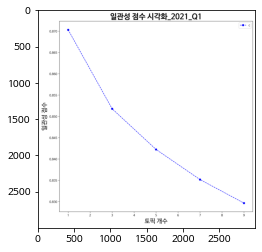

In [82]:
image = Image.open(f'/content/drive/MyDrive/LIS3813/images/coherence_scores_fig{y_q}.png')

plt.imshow(image)

In [ ]:
lda_model_2021_Q1 = LdaModel(corpus=corpus, num_topics=2, id2word=dic, passes=50, random_state=42)

In [84]:
coherence_lda_model = CoherenceModel(model=lda_model_2021_Q1, texts=texts, dictionary=dic, coherence='c_v')
coherence_lda = coherence_lda_model.get_coherence()
print('일관성 점수: ', coherence_lda)

일관성 점수:  0.8600042969712702


In [85]:
topics = lda_model_2021_Q1.print_topics()
for topic in topics:
  print(topic)

(0, '0.054*"여자" + 0.053*"사람" + 0.040*"여성" + 0.022*"거지" + 0.020*"한남" + 0.016*"사회" + 0.016*"평등" + 0.015*"한국" + 0.013*"주장" + 0.013*"페미니스트"')
(1, '0.057*"생각" + 0.054*"남자" + 0.040*"페미니즘" + 0.031*"남성" + 0.028*"차별" + 0.025*"여대" + 0.020*"혐오" + 0.013*"군대" + 0.013*"학교" + 0.012*"집단"')


In [86]:
lda_vis_2021_Q1 = pyLDAvis.gensim_models.prepare(lda_model_2021_Q1, corpus, dic, sort_topics=False)
pyLDAvis.save_html(lda_vis_2021_Q1, '/content/drive/MyDrive/LIS3813/images/lda_vis_2021_Q1.html')
pyLDAvis.display(lda_vis_2021_Q1)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
